In [2]:
import re
import pandas as pd
import string
import json
import requests
import numpy as np

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers, Model
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, SpatialDropout1D, LSTM, Bidirectional, TimeDistributed, Input
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils.vis_utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

In [4]:
train_url = "https://raw.githubusercontent.com/paresh-nayyar/CSCI-544_NLP/master/data/TER_text%26emotions_train.csv?token=GHSAT0AAAAAABTJRLBYVXSOARHMDFFNHTE4YS7SRZQ"
test_url = "https://raw.githubusercontent.com/paresh-nayyar/CSCI-544_NLP/master/data/TER_text%26emotions_test.csv?token=GHSAT0AAAAAABTJRLBY4RS7EY32FEFPQCAEYS7SRYA"
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)
len(train_df),len(test_df)

(107754, 26939)

In [5]:
from google.colab import drive
drive.mount('/content/drive')
!ls
%cd drive/My Drive/NLP


Mounted at /content/drive
drive  sample_data
/content/drive/My Drive/NLP


In [6]:
from gensim.models import FastText
fasttext_url = "./fasttext_model.model"
embeddings_index = FastText.load(fasttext_url)

In [7]:
label_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
y_train = train_df[label_names].values
y_test = test_df[label_names].values

train_df['doc_len'] = train_df['tweet'].astype(str).apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
#max_seq_len = train_df['doc_len'].max()
print(max_seq_len)

28


In [8]:
processed_docs_train = train_df['tweet'].astype(str).tolist()
processed_docs_test = test_df['tweet'].astype(str).tolist() 
num_classes = len(label_names)

In [9]:
MAX_NB_WORDS = 200000

In [23]:
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
total_docs=[]
total_docs.extend(processed_docs_train)
total_docs.extend(processed_docs_test)
#tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
tokenizer.fit_on_texts(total_docs)
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
#print(word_seq_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print(len(word_index))
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
print(word_seq_train[2])
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

tokenizing input data...
235929
dictionary size:  235929
[   59    92 10454     8    26    13    56   618    53    14  9069     8
   144    13    56 34369    45   405 72835  3975   618    53    10  6391
     8    26    13    56]


In [11]:
#training params
batch_size = 64
num_epochs = 8 

#model parameters
num_filters = 128 
num_kernels=200
stride=1
embed_dim = 300
weight_decay = 1e-4

#parallel layers 
kernel_size=7
kernel_size_p1=3
kernel_size_p2=6
kernel_size_p3=9
kernel_size_p4=12

In [12]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    #print(word)

    if embeddings_index.wv.__contains__(word): 

        embedding_vector = embeddings_index.wv[word]
    
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
#print(embedding_matrix)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [13]:
print(len(embedding_matrix[34]))
print(words_not_found)

300
[]


In [14]:
#LSTM Params

lstm_out1 = 150
bilstm_out1 = 96
lstm_out2 = 32
dropout = 0.2
recurrent_dropout = 0.2

In [15]:
def get_bilstm():
  inputt = Input(shape=(max_seq_len,))
  model = Embedding(nb_words, embed_dim,weights=[embedding_matrix],input_length=max_seq_len, trainable = False)(inputt)
  model =  Bidirectional (LSTM (lstm_out1, return_sequences=True, recurrent_dropout = 0.2, dropout = 0.2 ), merge_mode='concat')(model)
  model = TimeDistributed(Dense(10,activation='relu'))(model)
  model = Flatten()(model)
  model = Dense(64,activation='relu')(model)
  output = Dense(num_classes,activation='sigmoid')(model)
  model = Model(inputt,output)
  model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [16]:
def get_lstm():
  model = Sequential()
  model.add(Embedding(nb_words, embed_dim,
            weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
  model.add(LSTM(lstm_out1, recurrent_dropout = 0.2, dropout = 0.2))
  #model.add(MaxPooling1D(2))
  model.add(Dense(64, activation='relu'))

  model.add(Dense(num_classes, activation='sigmoid'))
  model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

  model.summary()
  return model

In [17]:
import matplotlib.pyplot as plt
def plotAcc(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def plotLoss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [18]:
def accuracy(model,test,y_test):
  predictions = model.predict(test)
  pred_labels = np.argmax(predictions, axis=1)
  y_test_labels = [np.where(x==1)[0][0] for x in y_test]
  print(np.sum(y_test_labels == pred_labels)/len(pred_labels))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 300)           60000000  
                                                                 
 lstm (LSTM)                 (None, 150)               270600    
                                                                 
 dense (Dense)               (None, 64)                9664      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 60,280,654
Trainable params: 280,654
Non-trainable params: 60,000,000
_________________________________________________________________
Epoch 1/8
1516/1516 [==============================] - 376s 240ms/step - loss: 0.1434 - accuracy: 0.9528 - val_loss: 0.0990 - val_accuracy: 0.9659
Epoch 2/8
1516/1516 [==

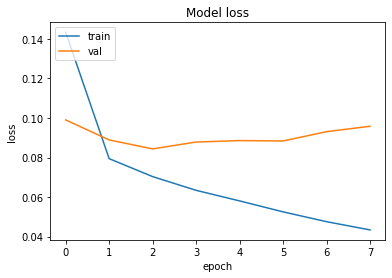

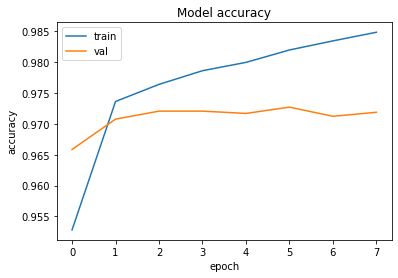

In [21]:
model = get_lstm()

history = model.fit(word_seq_train, y_train, batch_size=batch_size, 
                    epochs=num_epochs, validation_split=0.1, shuffle=True, verbose = 1)
predictions = model.predict(word_seq_test)
pred_labels = np.argmax(predictions, axis=1)
y_test = test_df[label_names].values

y_test_labels = [np.where(x==1)[0][0] for x in y_test]

print(np.sum(y_test_labels == pred_labels)/len(pred_labels))

plotLoss(history)
plotAcc(history)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 28, 300)           60000000  
                                                                 
 bidirectional_4 (Bidirectio  (None, 28, 300)          541200    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 28, 10)           3010      
 tributed)                                                       
                                                                 
 flatten_4 (Flatten)         (None, 280)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                1798

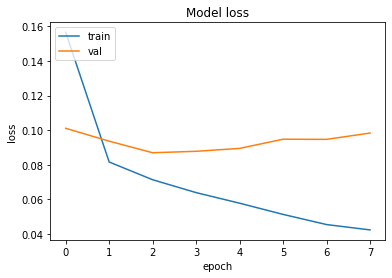

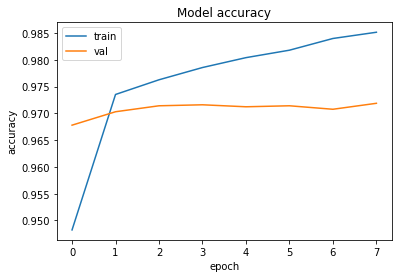

In [24]:
model = get_bilstm()
history = model.fit(word_seq_train, y_train, batch_size=batch_size, 
                    epochs=8, validation_split=0.1, shuffle=True, verbose = 1)
predictions = model.predict(word_seq_test)
# pred_labels = np.argmax(predictions, axis=1)
# y_test = test_df[label_names].values
# accuracy(word_seq_test,)
# y_test_labels = [np.where(x==1)[0][0] for x in y_test]

# print(np.sum(y_test_labels == pred_labels)/len(pred_labels))
plotLoss(history)
plotAcc(history)